# 토픽모델링 (Topic Modeling)

# 0 환경

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 런타임 재시작 !

In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1 잠재의미분석 (Latent Semantic Analysis LSA)

In [ ]:
from collections import defaultdict

word2idx = defaultdict(lambda: len(word2idx))

In [ ]:
doc = 'kit kit test test'

In [ ]:
for token in doc.split():
    word2idx[token]

In [ ]:
dict(word2idx)

{'keyword': 0, 'kit': 1, 'test': 2}

In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import randomized_svd

class LSA :
    def __init__(self, doc_ls, topic_num):
        self.doc_ls = doc_ls
        self.topic_num = topic_num
        self.term2idx, self.idx2term = self.toIdxDict(' '.join(doc_ls).split())
        self.doc2idx, self.idx2doc = self.toIdxDict(doc_ls)

        self.tdm = self.TDM(doc_ls)
        self.U, self.s, self.VT = self.SVD(self.tdm)


        self.term_mat = self.TermVectorMatrix(self.U, self.s, topic_num)
        self.doc_mat = self.DocVectorMatrix(self.s, self.VT, topic_num)
        self.term_doc_mat = self.TermDocVectorMatrix(self.U, self.s, self.VT, topic_num)

        self.term_sim = self.TermSimilarityMatrix(np.asarray(self.term_mat).T)
        self.doc_sim = self.DocSimilarityMartrix(np.asarray(self.doc_mat).T)

    # 리스트내 값을 index로 변환하는 dict과
    # index를 리스트내 값으로 변환하는 dict
    def toIdxDict(self, ls) :
        any2idx = defaultdict(lambda : len(any2idx))
        idx2any = defaultdict()

        for item in ls:
            any2idx[item]
            idx2any[any2idx[item]] = item

        print(idx2any)
        return any2idx, idx2any

    def TDM(self, doc_ls):
        # 행(토큰크기), 열(문서갯수)로 TDM 생성
        tdm = np.zeros([len(self.term2idx.keys()), len(doc_ls)])

        for doc_idx, doc in enumerate(doc_ls) :
            for term in doc.split() :
              #등장한 단어를 dictionary에서 위치를 탐색하여 빈도수 세기
              tdm[self.term2idx[term], doc_idx] += 1
        self.tdm = tdm

        return tdm

    # 특이값 분해
    def SVD(self, tdm):
        U, s, VT = randomized_svd(tdm,
                                  n_components=self.topic_num,
                                  n_iter=10,
                                  random_state=None)

        U, s, VT = np.linalg.svd(tdm, full_matrices=True)
        return U, s, VT

    # 토픽별 주요 키워드 출력
    def TopicModeling(self, count = 3) :
        topic_num = self.topic_num

        for i in range(topic_num) :
            score = self.U[:,i:i+1].T
            print(score)
            sorted_index = np.flip(np.argsort(-score),0)

            a = []
            for j in sorted_index[0,: count] :
                a.append((self.idx2term[j], score[0,j].round(3)))

            print("Topic {} - {}".format(i+1,a ))

    def vectorSimilarity(self, matrix) :
        cos_sim = cosine_similarity(matrix, matrix)
        return cos_sim

    # 키워드를 입력했을 때 단어 벡터 반환
    def GetTermVector(self, term):
        vec = self.term_mat[self.term2idx[term],:]
        print('{} = {}'.format(term, vec))
        return vec

    # 문서를 입력했을 때 문서 벡터 반환
    def GetDocVector(self, doc):
        vec = self.doc_mat.T[self.doc2idx[doc]:self.doc2idx[doc]+1,:]
        print('{} = {}'.format(doc, vec))
        return vec

    def Compression(self, round_num=0) :
        print(self.tdm)
        print(self.term_doc_mat.round(round_num))

    def TermVectorMatrix(self, u, s, topic_num):
        term_mat = np.matrix(u[:, :topic_num])# * np.diag(s[:topic_num])
        return term_mat

    def DocVectorMatrix(self, s, vt, topic_num):
        doc_mat = np.matrix(vt[:topic_num,:])
        return doc_mat

    def TermDocVectorMatrix(self, u, s, vt, topic_num):
        term_doc_mat = np.matrix(u[:, :topic_num]) * np.diag(s[:topic_num])  * np.matrix(vt[:topic_num,:])
        return term_doc_mat

    def TermSimilarityMatrix(self, termVectorMatrix):
        return self.vectorSimilarity(termVectorMatrix.T)

    def GetTermSimilarity(self, term1, term2):
        sim = self.term_sim[self.term2idx[term1], self.term2idx[term2]]
        print("({},{}) term similarity = {}".format(term1, term2, sim))
        return sim

    def DocSimilarityMartrix(self,docVectorMatrix):
        return self.vectorSimilarity(docVectorMatrix)

    def GetDocSimilarity(self, doc1, doc2):
        sim = self.doc_sim[self.doc2idx[doc1], self.doc2idx[doc2]]
        print("('{}','{}') doc similarity = {}".format(doc1, doc2, sim))
        return sim

In [ ]:
doc_ls = [
    '바나나 사과 포도 포도 짜장면',
    '사과 포도',
    '포도 바나나',
    '짜장면 짬뽕 탕수육',
    '볶음밥 탕수육',
    '짜장면 짬뽕',
    '라면 스시',
    '스시 짜장면',
    '가츠동 스시 소바',
    '된장찌개 김치찌개 김치',
    '김치 된장 짜장면',
    '비빔밥 김치'
]
lsa = LSA(doc_ls, 4)
print('== 토픽 모델링 ==')
lsa.TopicModeling(3)

defaultdict(None, {0: '바나나', 1: '사과', 2: '포도', 3: '짜장면', 4: '짬뽕', 5: '탕수육', 6: '볶음밥', 7: '라면', 8: '스시', 9: '가츠동', 10: '소바', 11: '된장찌개', 12: '김치찌개', 13: '김치', 14: '된장', 15: '비빔밥'})
defaultdict(None, {0: '바나나 사과 포도 포도 짜장면', 1: '사과 포도', 2: '포도 바나나', 3: '짜장면 짬뽕 탕수육', 4: '볶음밥 탕수육', 5: '짜장면 짬뽕', 6: '라면 스시', 7: '스시 짜장면', 8: '가츠동 스시 소바', 9: '된장찌개 김치찌개 김치', 10: '김치 된장 짜장면', 11: '비빔밥 김치'})
== 토픽 모델링 ==
[[-0.34843127 -0.34843127 -0.69686254 -0.48563449 -0.12448389 -0.0736207
  -0.00783718 -0.00733397 -0.06889362 -0.0082077  -0.0082077  -0.00922069
  -0.00922069 -0.07739641 -0.0599366  -0.00823912]]
Topic 1 - [('라면', -0.007), ('볶음밥', -0.008), ('가츠동', -0.008)]
[[-0.19370961 -0.19370961 -0.38741921  0.58415588  0.3555557   0.24835482
   0.04982669  0.05136218  0.25600828  0.06425309  0.06425309  0.0845808
   0.0845808   0.33700147  0.18480907  0.06761161]]
Topic 2 - [('짜장면', 0.584), ('짬뽕', 0.356), ('김치', 0.337)]
[[-0.01592593 -0.01592593 -0.03185185  0.07468389  0.10291629  0.0884251
   0.02671012  

In [ ]:
import pandas as pd
pd.DataFrame(lsa.tdm, columns=lsa.idx2doc, index=lsa.term2idx)

,0,1,2,3,4,5,6,7,8,9,10,11
바나나,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
사과,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
포도,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
짜장면,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
짬뽕,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
탕수육,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
볶음밥,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
라면,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
스시,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
가츠동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
np.linalg.svd?

In [ ]:
doc_ls = [
    '바나나 사과 포도 포도 짜장면',
    '사과 포도',
    '포도 바나나',
    '짜장면 짬뽕 탕수육',
    '볶음밥 탕수육',
    '짜장면 짬뽕',
    '라면 스시',
    '스시 짜장면',
    '가츠동 스시 소바',
    '된장찌개 김치찌개 김치',
    '김치 된장 짜장면',
    '비빔밥 김치'
]
lsa = LSA(doc_ls, 4)
X = lsa.TDM(doc_ls)
print('== 토픽 모델링 ==')
lsa.TopicModeling(4)

defaultdict(None, {0: '바나나', 1: '사과', 2: '포도', 3: '짜장면', 4: '짬뽕', 5: '탕수육', 6: '볶음밥', 7: '라면', 8: '스시', 9: '가츠동', 10: '소바', 11: '된장찌개', 12: '김치찌개', 13: '김치', 14: '된장', 15: '비빔밥'})
defaultdict(None, {0: '바나나 사과 포도 포도 짜장면', 1: '사과 포도', 2: '포도 바나나', 3: '짜장면 짬뽕 탕수육', 4: '볶음밥 탕수육', 5: '짜장면 짬뽕', 6: '라면 스시', 7: '스시 짜장면', 8: '가츠동 스시 소바', 9: '된장찌개 김치찌개 김치', 10: '김치 된장 짜장면', 11: '비빔밥 김치'})
== 토픽 모델링 ==
[[-0.34843127 -0.34843127 -0.69686254 -0.48563449 -0.12448389 -0.0736207
  -0.00783718 -0.00733397 -0.06889362 -0.0082077  -0.0082077  -0.00922069
  -0.00922069 -0.07739641 -0.0599366  -0.00823912]]
Topic 1 - [('라면', -0.007), ('볶음밥', -0.008), ('가츠동', -0.008), ('소바', -0.008)]
[[-0.19370961 -0.19370961 -0.38741921  0.58415588  0.3555557   0.24835482
   0.04982669  0.05136218  0.25600828  0.06425309  0.06425309  0.0845808
   0.0845808   0.33700147  0.18480907  0.06761161]]
Topic 2 - [('짜장면', 0.584), ('짬뽕', 0.356), ('김치', 0.337), ('스시', 0.256)]
[[-0.01592593 -0.01592593 -0.03185185  0.07468389  0.1029

In [ ]:
print('\n== 단어 벡터 ==')
lsa.GetTermVector('사과'), lsa.GetTermVector('짜장면')


== 단어 벡터 ==
사과 = [[-0.34843127 -0.19370961 -0.01592593 -0.03744775]]
짜장면 = [[-0.48563449  0.58415588  0.07468389  0.18737521]]


(matrix([[-0.34843127, -0.19370961, -0.01592593, -0.03744775]]),
 matrix([[-0.48563449,  0.58415588,  0.07468389,  0.18737521]]))

In [ ]:
lsa.GetTermVector('사과'), lsa.GetTermVector('바나나')

사과 = [[-0.34843127 -0.19370961 -0.01592593 -0.03744775]]
바나나 = [[-0.34843127 -0.19370961 -0.01592593 -0.03744775]]


(matrix([[-0.34843127, -0.19370961, -0.01592593, -0.03744775]]),
 matrix([[-0.34843127, -0.19370961, -0.01592593, -0.03744775]]))

In [ ]:
print('\n== 단어 유사도 ==')
lsa.GetTermSimilarity('사과','바나나')
lsa.GetTermSimilarity('사과','짜장면')
lsa.GetTermSimilarity('포도','짜장면')
lsa.GetTermSimilarity('사과','스시')


== 단어 유사도 ==
(사과,바나나) term similarity = 1.0
(사과,짜장면) term similarity = 0.15191335214807106
(포도,짜장면) term similarity = 0.15191335214807017
(사과,스시) term similarity = -0.040978252027327154


-0.040978252027327154

In [ ]:

print('\n== 문서 벡터 ==')
lsa.GetDocVector('사과 포도')
lsa.GetDocVector('짜장면 짬뽕')


== 문서 벡터 ==
사과 포도 = [[-0.32422891 -0.2375544  -0.02301229 -0.05619723]]
짜장면 짬뽕 = [[-0.18924633  0.38413621  0.08554157  0.26853634]]


matrix([[-0.18924633,  0.38413621,  0.08554157,  0.26853634]])

In [ ]:
lsa.GetDocVector('사과 포도'), lsa.GetDocVector('포도 바나나')

사과 포도 = [[-0.32422891 -0.2375544  -0.02301229 -0.05619723]]
포도 바나나 = [[-0.32422891 -0.2375544  -0.02301229 -0.05619723]]


(matrix([[-0.32422891, -0.2375544 , -0.02301229, -0.05619723]]),
 matrix([[-0.32422891, -0.2375544 , -0.02301229, -0.05619723]]))

In [ ]:
print('\n== 문서 유사도 ==')
lsa.GetDocSimilarity('사과 포도', '포도 바나나')
lsa.GetDocSimilarity('사과 포도', '라면 스시')


== 문서 유사도 ==
('사과 포도','포도 바나나') doc similarity = 0.9999999999999999
('사과 포도','라면 스시') doc similarity = -0.0435217055045559


-0.0435217055045559

## 1.2 sklearn 활용

### 1) 토픽모델링

In [ ]:
doc_ls = [
    '바나나 사과 포도 포도 짜장면',
    '사과 포도',
    '포도 바나나',
    '짜장면 짬뽕 탕수육',
    '볶음밥 탕수육',
    '짜장면 짬뽕',
    '라면 스시',
    '스시 짜장면',
    '가츠동 스시 소바',
    '된장찌개 김치찌개 김치',
    '김치 된장 짜장면',
    '비빔밥 김치'
]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_topic= 4

tfidf_vect = TfidfVectorizer(max_features= 1000, max_df = 0.5, smooth_idf=True)
tfidf = tfidf_vect.fit_transform(doc_ls)
svd = TruncatedSVD(n_components=n_topic, algorithm='randomized', n_iter=100)
u_sigma = svd.fit_transform(tfidf)
svd.components_.shape

(4, 16)

In [ ]:
TruncatedSVD?

In [ ]:
vocab = tfidf_vect.get_feature_names_out() # 단어 집합. 1,000개의 단어가 저장됨.
n = 3
for idx, topic in enumerate(svd.components_):
    print("Topic %d:" % (idx), [(vocab[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])

Topic 0: [('포도', 0.58251), ('짜장면', 0.49916), ('바나나', 0.32971)]
Topic 1: [('짜장면', 0.43992), ('짬뽕', 0.39143), ('스시', 0.31495)]
Topic 2: [('스시', 0.70278), ('라면', 0.3528), ('소바', 0.25327)]
Topic 3: [('김치', 0.68201), ('비빔밥', 0.37258), ('김치찌개', 0.27163)]


### 2) 단어벡터

In [ ]:
svd.components_.T

array([[ 0.03615365,  0.06740048,  0.25326653,  0.02997407],
       [ 0.10978603,  0.15347979, -0.21577691,  0.68200798],
       [ 0.01834125,  0.03284554, -0.07776122,  0.27162684],
       [ 0.09862335,  0.12078756, -0.09834554,  0.25478532],
       [ 0.01834125,  0.03284554, -0.07776122,  0.27162684],
       [ 0.05470036,  0.09988705,  0.35279702,  0.04111418],
       [ 0.3297113 , -0.28961955,  0.01226021,  0.00405599],
       [ 0.04131708,  0.07490311, -0.12482955, -0.14359192],
       [ 0.02775026,  0.04867686, -0.10832038,  0.37257919],
       [ 0.3297113 , -0.28961955,  0.01226021,  0.00405599],
       [ 0.03615365,  0.06740048,  0.25326653,  0.02997407],
       [ 0.21640648,  0.31494725,  0.70278052,  0.0752597 ],
       [ 0.4991573 ,  0.43992407, -0.07237264, -0.02641656],
       [ 0.29964085,  0.39142644, -0.29248516, -0.27990967],
       [ 0.1641898 ,  0.23904844, -0.25719626, -0.2732592 ],
       [ 0.58250527, -0.51167464,  0.02166027,  0.00716578]])

In [ ]:
# 단어벡터
for i in range(len(vocab)) :
    print("{} : {}".format(vocab[i], svd.components_.T[i]))

가츠동 : [0.03615365 0.06740048 0.25326653 0.02997407]
김치 : [ 0.10978603  0.15347979 -0.21577691  0.68200798]
김치찌개 : [ 0.01834125  0.03284554 -0.07776122  0.27162684]
된장 : [ 0.09862335  0.12078756 -0.09834554  0.25478532]
된장찌개 : [ 0.01834125  0.03284554 -0.07776122  0.27162684]
라면 : [0.05470036 0.09988705 0.35279702 0.04111418]
바나나 : [ 0.3297113  -0.28961955  0.01226021  0.00405599]
볶음밥 : [ 0.04131708  0.07490311 -0.12482955 -0.14359192]
비빔밥 : [ 0.02775026  0.04867686 -0.10832038  0.37257919]
사과 : [ 0.3297113  -0.28961955  0.01226021  0.00405599]
소바 : [0.03615365 0.06740048 0.25326653 0.02997407]
스시 : [0.21640648 0.31494725 0.70278052 0.0752597 ]
짜장면 : [ 0.4991573   0.43992407 -0.07237264 -0.02641656]
짬뽕 : [ 0.29964085  0.39142644 -0.29248516 -0.27990967]
탕수육 : [ 0.1641898   0.23904844 -0.25719626 -0.2732592 ]
포도 : [ 0.58250527 -0.51167464  0.02166027  0.00716578]


In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def calc_similarity_matrix(vectors) :
    def cosine_similarity(a, b) :
        return dot(a, b)/(norm(a)*norm(b))

    n_word = len(vectors)
    similarity_matrix = np.zeros((n_word, n_word))

    for i in range(n_word) :
        for j in range(i, n_word) :
            similarity_matrix[j, i] = cosine_similarity(vectors[i], vectors[j]).round(4)

    return similarity_matrix

In [ ]:
import seaborn as sns

def visualize_similarity(similarity_matrix) :
    uniform_data = similarity_matrix
    mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
    plt.rcParams['figure.figsize'] = [8, 6]
    features=doc_ls
    ax = sns.heatmap(uniform_data, mask=mask, xticklabels=features, yticklabels=features,
                    annot=True, fmt=".2f",annot_kws={'size':8}, cmap='coolwarm')

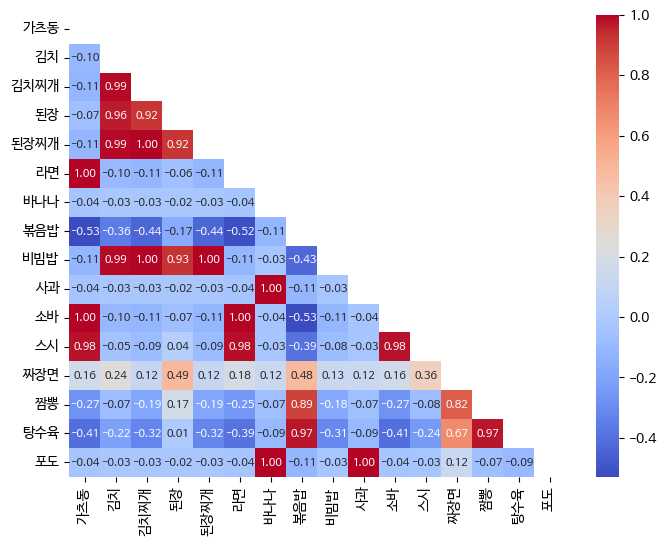

In [ ]:
word_vectors = svd.components_.T
word_similarity_matrix = calc_similarity_matrix(word_vectors)
visualize_similarity(word_similarity_matrix)

### 3) 문서벡터

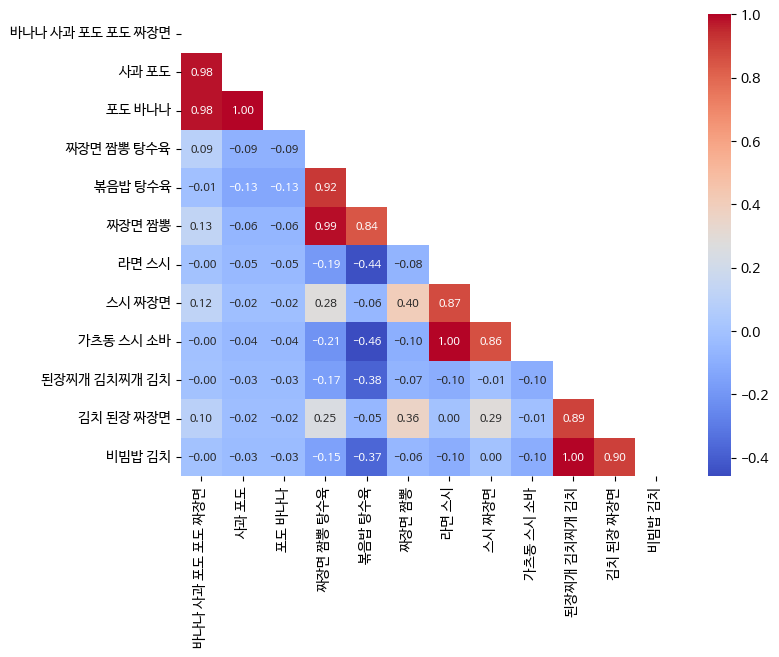

In [ ]:
doc_vectors = u_sigma/svd.singular_values_ # U -> 좌특이벡터만 뽑기
doc_similarity_matrix = calc_similarity_matrix(doc_vectors)
visualize_similarity(doc_similarity_matrix)

### 4) 벡터 시각화

- manifold.TSNE() : t-SNE(t분포 Stochastic Neighbor Embedding) 차원 축소 기법의 하나

In [ ]:
vectors = word_vectors
labels = tfidf_vect.get_feature_names_out()

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_vectors(vectors, labels):
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)
    #labels = vocab

    plt.figure(figsize=(10, 6))
    plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

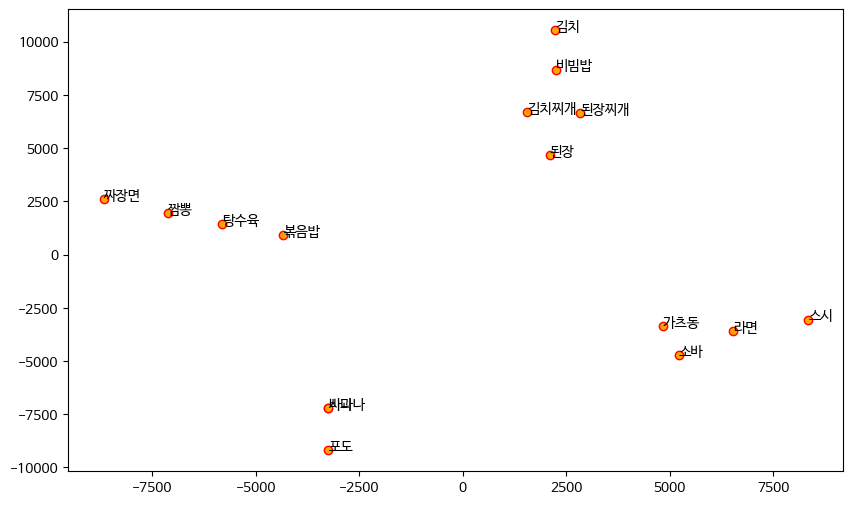

In [ ]:
visualize_vectors(vectors, labels)

### 5) 파이프라인 사용

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def my_tokenizer(text):
    return [w for w in text.split() if len(w) > 1]

lsa_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer = my_tokenizer)),
    ('tfidf', TfidfTransformer(smooth_idf=True)),
    ('lsa', TruncatedSVD(n_components=n_topic, algorithm='randomized', n_iter=100)),
])

lsa_pipeline.fit(doc_ls)

In [ ]:
lsa = lsa_pipeline.named_steps['lsa']
count_vect = lsa_pipeline.named_steps['vect']

In [ ]:
vocab = count_vect.get_feature_names_out() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=3):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lsa.components_,vocab)

Topic 0: [('포도', 0.58251), ('짜장면', 0.49916), ('바나나', 0.32971)]
Topic 1: [('짜장면', 0.43992), ('짬뽕', 0.39143), ('스시', 0.31495)]
Topic 2: [('스시', 0.70278), ('라면', 0.3528), ('소바', 0.25327)]
Topic 3: [('김치', 0.68201), ('비빔밥', 0.37258), ('김치찌개', 0.27163)]


## 1.3 gensim 활용

### 1) 토픽모델링

In [ ]:
docs = [
    '바나나 사과 포도 포도',
    '사과 포도',
    '포도 바나나',
    '짜장면 짬뽕 탕수욕',
    '볶음밥 탕수욕',
    '짜장면 짬뽕',
    '라면 스시',
    '스시',
    '가츠동 스시 소바',
    '된장찌개 김치찌개 김치',
    '김치 된장',
    '비빔밥 김치'
]

In [ ]:
doc_ls = [doc.split() for doc in docs]
doc_ls[0]

['바나나', '사과', '포도', '포도']

In [ ]:
LsiModel?

In [ ]:
from gensim import corpora
from gensim.models import LsiModel
from gensim.models import TfidfModel

n_dim = 4

id2word = corpora.Dictionary(doc_ls)
corpus_TDM = [id2word.doc2bow(text) for text in doc_ls]
tfidf = TfidfModel(corpus_TDM) #train
corpus_TFIDF = tfidf[corpus_TDM] #predict
model_LSA = LsiModel(corpus_TFIDF, id2word=id2word, num_topics=n_dim)

for top in model_LSA.print_topics(n_dim, 3):
    print(top)

(0, '0.738*"포도" + 0.477*"사과" + 0.477*"바나나"')
(1, '0.634*"짜장면" + 0.634*"짬뽕" + 0.413*"탕수욕"')
(2, '-0.854*"스시" + -0.386*"라면" + -0.246*"가츠동"')
(3, '-0.658*"김치" + -0.441*"된장" + -0.441*"비빔밥"')


In [ ]:
model_LSA.projection.u

array([[ 0.47703053, -0.        ,  0.        ,  0.        ],
       [ 0.47703053,  0.        , -0.        , -0.        ],
       [ 0.73816241, -0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.63412579,  0.        ,  0.        ],
       [ 0.        ,  0.63412579,  0.        ,  0.        ],
       [-0.        ,  0.41262633,  0.        ,  0.        ],
       [-0.        ,  0.15971375,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.38630676,  0.        ],
       [-0.        ,  0.        , -0.85423448,  0.        ],
       [ 0.        ,  0.        , -0.24601884,  0.        ],
       [-0.        ,  0.        , -0.24601884,  0.        ],
       [ 0.        ,  0.        , -0.        , -0.65829341],
       [ 0.        ,  0.        , -0.        , -0.29831745],
       [ 0.        ,  0.        , -0.        , -0.29831745],
       [-0.        ,  0.        , -0.        , -0.44083057],
       [ 0.        ,  0.        , -0.        , -0.44083057]])

In [ ]:
from gensim.matutils import sparse2full
corpus_VT = model_LSA[corpus_TDM]
VT = [sparse2full(doc_vector, n_dim).tolist() for doc_vector in corpus_VT]
VT

[[2.4303858280181885, 0.0, 0.0, 0.0],
 [1.2151929140090942, 0.0, 0.0, 0.0],
 [1.2151929140090942, 0.0, 0.0, 0.0],
 [0.0, 1.680877923965454, 0.0, 0.0],
 [0.0, 0.5723400712013245, 0.0, 0.0],
 [0.0, 1.2682515382766724, 0.0, 0.0],
 [0.0, 0.0, -1.2405412197113037, 0.0],
 [0.0, 0.0, -0.8542344570159912, 0.0],
 [0.0, 0.0, -1.3462721109390259, 0.0],
 [0.0, 0.0, 0.0, -1.2549283504486084],
 [0.0, 0.0, 0.0, -1.0991239547729492],
 [0.0, 0.0, 0.0, -1.0991239547729492]]

### 2) 단어벡터

In [ ]:
for i in id2word.keys() :
    print("{} : {}".format(id2word[i], model_LSA.projection.u[i]))

바나나 : [ 0.47703053 -0.          0.          0.        ]
사과 : [ 0.47703053  0.         -0.         -0.        ]
포도 : [ 0.73816241 -0.          0.          0.        ]
짜장면 : [0.         0.63412579 0.         0.        ]
짬뽕 : [0.         0.63412579 0.         0.        ]
탕수욕 : [-0.          0.41262633  0.          0.        ]
볶음밥 : [-0.          0.15971375  0.          0.        ]
라면 : [ 0.          0.         -0.38630676  0.        ]
스시 : [-0.          0.         -0.85423448  0.        ]
가츠동 : [ 0.          0.         -0.24601884  0.        ]
소바 : [-0.          0.         -0.24601884  0.        ]
김치 : [ 0.          0.         -0.         -0.65829341]
김치찌개 : [ 0.          0.         -0.         -0.29831745]
된장찌개 : [ 0.          0.         -0.         -0.29831745]
된장 : [-0.          0.         -0.         -0.44083057]
비빔밥 : [ 0.          0.         -0.         -0.44083057]


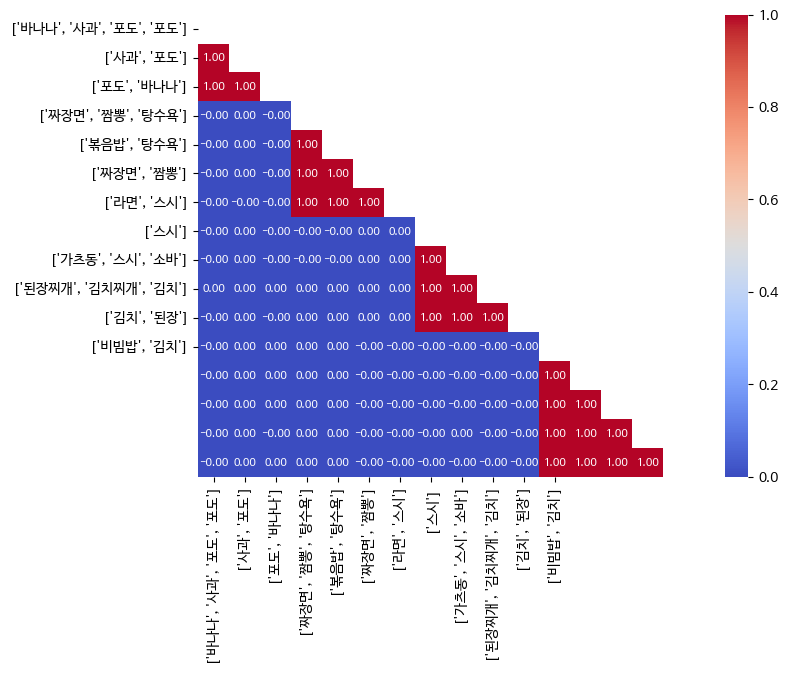

In [ ]:
word_vectors = model_LSA.projection.u
word_similarity_matrix = calc_similarity_matrix(word_vectors)
visualize_similarity(word_similarity_matrix)

### 3) 문서벡터

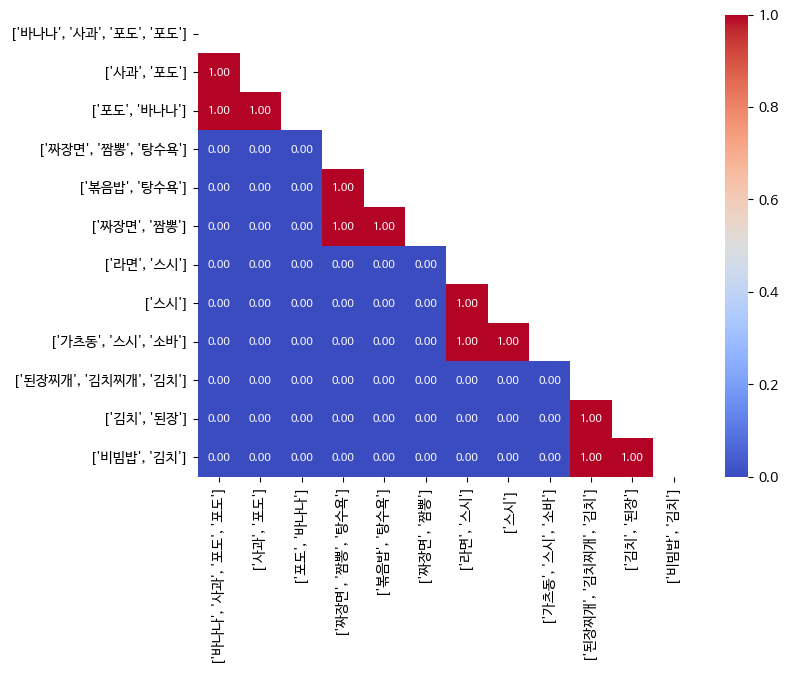

In [ ]:
from gensim.matutils import sparse2full
corpus_V = model_LSA[corpus_TDM]
V = [sparse2full(doc_vector, n_dim).tolist() for doc_vector in corpus_VT]

doc_vectors = V
doc_similarity_matrix = calc_similarity_matrix(doc_vectors)
visualize_similarity(doc_similarity_matrix)

### 4) 벡터시각화

In [ ]:
vectors = word_vectors
labels = [k for k in id2word.values()]

visualize_vectors(vectors, labels)

# 2 잠재디리클레할당(LDA, Latent Dirichlet Allocation)

## 2.1 직접구현

### 1) 직접 구현

In [ ]:
import random
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
doc_ls = [
    "Cute kitty",
    "Eat rice or cake",
    "Kitty and hamster",
    "Eat bread",
    "Rice, bread and cake",
    "Cute hamster eats bread and cake"
]

In [ ]:
sw = stopwords.words()

In [ ]:
WordNetLemmatizer?

In [ ]:
wnl = WordNetLemmatizer()
tokens = [
    [wnl.lemmatize(token.lower()) for token in word_tokenize(doc) if token.lower() not in sw]
    for doc in doc_ls]

In [ ]:
# training_set = []
# for doc in doc_ls:
#     # token_doc = []
#     # for token in word_tokenize(doc.lower()):
#     #     if token not in sw and len(token) > 1:
#     #         token_doc.append(wnl.lemmatize(token))
#     token_doc = [wnl.lemmatize(token) for token in word_tokenize(doc.lower()) if len(token) > 1 and token not in sw]
#     training_set.append(token_doc)
ps = PorterStemmer()

training_set = [
    [ps.stem(wnl.lemmatize(token)) for token in word_tokenize(doc.lower()) if len(token) > 1 and token not in sw]
    for doc in doc_ls]

# training_set = [[token_doc] for doc in doc_ls]
training_set

[['cute', 'kitti'],
 ['eat', 'rice', 'cake'],
 ['kitti', 'hamster'],
 ['eat', 'bread'],
 ['rice', 'bread', 'cake'],
 ['cute', 'hamster', 'eat', 'bread', 'cake']]

In [ ]:
tokens = sum(training_set, [])

In [ ]:
set(tokens)

{'bread', 'cake', 'cute', 'eat', 'hamster', 'kitti', 'rice'}

In [ ]:
word2idx = {t: i for i, t in enumerate(set(tokens))}

In [ ]:
word2idx

{'hamster': 0,
 'kitti': 1,
 'eat': 2,
 'cute': 3,
 'rice': 4,
 'bread': 5,
 'cake': 6}

In [ ]:
doc2idx = {d: i for i, d in enumerate(doc_ls)}
doc2idx

{'Cute kitty': 0,
 'Eat rice or cake': 1,
 'Kitty and hamster': 2,
 'Eat bread': 3,
 'Rice, bread and cake': 4,
 'Cute hamster eats bread and cake': 5}

In [ ]:
import random

In [ ]:
random.randint(0, 1)

0

In [ ]:
# 랜덤하게 주제 할당
# doc_token_topic = [
#     (0, 0, 0)
# ]

k = 2

doc_tok_topic = []

for doc_idx, tokens in enumerate(training_set):
    for token in tokens:
        doc_tok_topic.append(
            (doc_idx, word2idx[token], random.randint(0, k-1))
        )
doc_tok_topic

[(0, 3, 0),
 (0, 1, 0),
 (1, 2, 1),
 (1, 4, 1),
 (1, 6, 0),
 (2, 1, 1),
 (2, 0, 1),
 (3, 2, 0),
 (3, 5, 1),
 (4, 4, 1),
 (4, 5, 1),
 (4, 6, 1),
 (5, 3, 1),
 (5, 0, 1),
 (5, 2, 0),
 (5, 5, 1),
 (5, 6, 0)]

In [ ]:
# Document, Token 별 Topic 카운트
a = 0.1
b = 0.001

doc_topic_cnt = [
    (1.1, 1.1), # 문서 1의 주제1, 주제2 빈도 a

]
tok_topic_cnt = [
    (1.001, 1.001) # 토큰 1의 주제 1 주제 2 빈도 b
]

doc_topic_cnt = [[a] * k for doc in doc_ls ]
tok_topic_cnt = [[b] * k for token in word2idx]

doc_topic_cnt, tok_topic_cnt

([[0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1]],
 [[0.001, 0.001],
  [0.001, 0.001],
  [0.001, 0.001],
  [0.001, 0.001],
  [0.001, 0.001],
  [0.001, 0.001],
  [0.001, 0.001]])

In [ ]:
for doc_idx, tok_idx, topic_idx in doc_tok_topic:
    doc_topic_cnt[doc_idx][topic_idx] += 1
    tok_topic_cnt[tok_idx][topic_idx] += 1

doc_topic_cnt, tok_topic_cnt

([[2.1, 0.1], [1.1, 2.1], [0.1, 2.1], [1.1, 1.1], [0.1, 3.1], [2.1, 3.1]],
 [[0.001, 2.001],
  [1.001, 1.001],
  [2.001, 1.001],
  [1.001, 1.001],
  [0.001, 2.001],
  [0.001, 3.001],
  [2.001, 1.001]])

In [ ]:
# 재할당 과정 반복
for epoch in range(20):
    for i, (doc_idx, tok_idx, topic_idx) in enumerate(doc_tok_topic):
        doc_topic_cnt[doc_idx][topic_idx] -= 1
        tok_topic_cnt[tok_idx][topic_idx] -= 1

        topic_probs = []
        for topic in range(k):
            # doc 내 주제 topic일 확률
            doc_prob = doc_topic_cnt[doc_idx][topic] / sum(doc_topic_cnt[doc_idx])
            # 주제 내 단어가 token일 확률
            tok_prob = tok_topic_cnt[tok_idx][topic] / sum([t[topic] for t in tok_topic_cnt])

            # doc 내 token이 topic일 확률
            topic_probs.append(doc_prob * tok_prob)

        # 가장 큰 주제 확률로 토픽 할당
        new_topic = np.argmax(topic_probs)
        doc_tok_topic[i] = (doc_idx, tok_idx, new_topic)
        doc_topic_cnt[doc_idx][new_topic] += 1
        tok_topic_cnt[tok_idx][new_topic] += 1


In [ ]:
# 토픽 모델링

idx2doc = {}
idx2word = {}

# 문서 별 주제 출력

# 주제 별 단어 출력


In [ ]:
doc_topic_cnt, tok_topic_cnt

([[0.10000000000000009, 2.1],
  [2.1, 1.1],
  [0.1, 2.1],
  [1.1, 1.1],
  [1.1, 2.1],
  [2.1, 3.1]],
 [[0.001, 2.001],
  [0.0009999999999998899, 2.001],
  [3.001, 0.0009999999999998899],
  [0.0009999999999998899, 2.001],
  [0.001, 2.001],
  [0.001, 3.001],
  [3.001, 0.0009999999999998899]])

In [ ]:
# 랜덤하게 주제 할당

# Document, Token 별 Topic 카운트

# 재할당 과정 반복

# 토픽 별 단어 추출

In [ ]:
lda = LDA(doc_ls, 2)
lda.TopicModeling(5)

## 2.2  sklearn 활용

### 1) 토픽모델링 (파이프라인 미사용)

- decomposition.LatentDirichletAllocation() : LDA 모델

In [ ]:
!pip install pyLDAvis

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

#뉴스 다운로드 및 전처리
def get_news(apply_split=True) :
    #20newsgroup 다운로드
    dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
    documents = dataset.data

    news_df = pd.DataFrame({'document':documents})
    news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ") # 특수 문자 제거
    news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) # 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
    news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())# 전체 단어에 대한 소문자 변환
    tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화

    stop_words = stopwords.words('english') # NLTK 불용어 조회

    if apply_split :
        return tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
    else :
        return tokenized_doc.apply(lambda x: ' '.join([item for item in x if item not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#공백으로 토큰 분리
def my_tokenizer(text):
    return text.split()

tokenized_docs = get_news(False)

In [6]:
tokenized_docs[:5]

0    well sure story seem biased. disagree statemen...
1    yeah, expect people read faq, etc. actually ac...
2    although realize principle strongest points, w...
3    notwithstanding legitimate fuss proposal, much...
4    well, change scoring playoff pool. unfortunate...
Name: clean_doc, dtype: object

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tfidf_vect = TfidfVectorizer(tokenizer = my_tokenizer)
tfidf = tfidf_vect.fit_transform(tokenized_docs)
lda = LatentDirichletAllocation(n_components=20,
                                max_iter=10,
                                learning_method='online',
                                random_state=100)

lda_output = lda.fit_transform(tfidf)

In [9]:
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, tfidf, tfidf_vect, n_jobs=1)
pyLDAvis.display(vis)

### 2) 토픽모델링 (파이프라인 사용)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tokenized_docs = get_news(False)
#파이프라이구성
lda_pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = my_tokenizer)),
    ('lda', LatentDirichletAllocation(n_components=20,
                                      max_iter=5,
                                      learning_method='online',
                                      random_state=100))])

lda_pipeline.fit(tokenized_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pipeline(steps=[('tfidf_vect',
                 TfidfVectorizer(tokenizer=<function my_tokenizer at 0x7f49631ea170>)),
                ('lda',
                 LatentDirichletAllocation(learning_method='online', max_iter=5,
                                           n_components=20,
                                           random_state=100))])

In [11]:
import pyLDAvis
import pyLDAvis.lda_model

tfidf_vect = lda_pipeline.named_steps['tfidf_vect']
tfidf = tfidf_vect.fit_transform(tokenized_docs)
lda = lda_pipeline.named_steps['lda']

vis = pyLDAvis.lda_model.prepare(lda, tfidf, tfidf_vect, n_jobs=1)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3) 하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

def tuning_hyperparams(train_data, n_jobs=1) :
    lda_pipeline = Pipeline([
        ('tfidf_vect', TfidfVectorizer(tokenizer = my_tokenizer)),
        ('lda', LatentDirichletAllocation(max_iter=10, random_state=100))
    ])

    search_params = {
        'tfidf_vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf_vect__use_idf': (True, False),
        'lda__n_components': [10, 20]
    }

    gs_lda = GridSearchCV(lda_pipeline, search_params, n_jobs=n_jobs)
    gs_lda = gs_lda.fit(train_data)
    print("Best score: {0}".format(gs_lda.best_score_))
    print("Best parameters set:")
    best_parameters = gs_lda.best_estimator_.get_params()
    for param_name in sorted(list(best_parameters.keys())):
        print("\t{0}: {1}".format(param_name, best_parameters[param_name]))
    return gs_lda.best_estimator_

lda_pipeline = tuning_hyperparams(tokenized_docs)

In [ ]:
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

tfidf_vect = lda_pipeline.named_steps['tfidf_vect']
tfidf = tfidf_vect.fit_transform(tokenized_docs)
lda = lda_pipeline.named_steps['lda']

vis = pyLDAvis.lda_model.prepare(lda, tfidf, tfidf_vect, n_jobs=1)
pyLDAvis.display(vis)

## 2.3 gensim 활용

### 1) 토픽모델링

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
from gensim import corpora
from gensim.models import LdaModel, TfidfModel

tokenized_docs = get_news()
id2word = corpora.Dictionary(tokenized_docs)
corpus_TDM = [id2word.doc2bow(doc) for doc in tokenized_docs]
tfidf = TfidfModel(corpus_TDM)
corpus_TFIDF = tfidf[corpus_TDM]

n = 20
lda = LdaModel(corpus=corpus_TFIDF,
               id2word=id2word,
               num_topics=n,
               random_state=100)

for t in lda.print_topics():
    print(t)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

(0, '0.001*"stats" + 0.001*"please," + 0.001*"sports" + 0.001*"henrik]" + 0.001*"posts" + 0.001*"played" + 0.000*"ford" + 0.000*"deleted" + 0.000*"safety" + 0.000*"readers"')
(1, '0.000*"tiff" + 0.000*"animation" + 0.000*"telnet" + 0.000*"floptical" + 0.000*"graphic" + 0.000*"orchid" + 0.000*"book?" + 0.000*"offense" + 0.000*"ethernet" + 0.000*"problems."')
(2, '0.001*"values" + 0.000*"cursor" + 0.000*"maine" + 0.000*"temp" + 0.000*"strikes" + 0.000*"meaningless" + 0.000*"too," + 0.000*"captain" + 0.000*"number?" + 0.000*"adjective"')
(3, '0.001*"port" + 0.001*"(deletion)" + 0.000*"borland" + 0.000*"cancer" + 0.000*"port." + 0.000*"responses" + 0.000*"where?" + 0.000*"linux" + 0.000*"luck." + 0.000*"grateful"')
(4, '0.001*"arab" + 0.001*"players" + 0.001*"for." + 0.001*"palestinian" + 0.001*"arabs" + 0.001*"------" + 0.001*"clemens" + 0.001*"phillies" + 0.000*"jews" + 0.000*"owners"')
(5, '0.003*"would" + 0.003*"know" + 0.003*"like" + 0.002*"people" + 0.002*"think" + 0.002*"could" + 0.

In [13]:
corpus_TDM = [id2word.doc2bow(doc) for doc in tokenized_docs]
tfidf = TfidfModel(corpus_TDM)
corpus_TFIDF = tfidf[corpus_TDM]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda, corpus_TFIDF, id2word, mds='tsne')
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2) 하이퍼파라미터 튜닝

- models.coherencemodel.CoherenceModel() : LDA에서 최적 토픽 개수를 추출하는 모델 (토픽의 응집력 계산)

In [15]:
from gensim import corpora
from gensim.models import LdaModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_perplexity(tokenized_docs, end, start=2, step=3) :
    id2word = corpora.Dictionary(tokenized_docs)
    corpus_TDM = [id2word.doc2bow(doc) for doc in tokenized_docs]
    tfidf = TfidfModel(corpus_TDM)
    corpus_TFIDF = tfidf[corpus_TDM]

    coherence_values = []
    perplexity_values = []
    model_list = []
    topic_n_list = []

    for num_topics in range(start, end, step):
        model = LdaModel(corpus_TFIDF, num_topics=num_topics, id2word = id2word)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=tokenized_docs,
                                        dictionary=id2word,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus_TFIDF))
        topic_n_list.append(num_topics)

    for t, c, p in zip(topic_n_list, coherence_values, perplexity_values) :
        print("topic_n={}, coherence : {}, perplexity : {}".format(t,c,p))

    return corpus_TFIDF, id2word, model_list, coherence_values, perplexity_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
from gensim import corpora
from gensim.models import LdaModel, TfidfModel

tokenized_docs = get_news()
corpus, id2word, model_list, coherence_values, perplexity_values = compute_coherence_perplexity(tokenized_docs, start=10, end=30, step=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_n=10, coherence : 0.5291393460440726, perplexity : -16.127430058267077
topic_n=20, coherence : 0.5768974319400265, perplexity : -21.943827517709508


In [17]:
lda_model = model_list[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='tsne')
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
